In [78]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns

# LOAD DATA

In [41]:
DATA_PATH = "BazaCut/"
FILIP_PATH = DATA_PATH + "wordsFilip/"
SEB_PATH = DATA_PATH + "wordsSebastian/"
MARCIN_PATH = DATA_PATH + "wordsMarcin/"
no_of_words = 30
prefixes = ["F","S","M"]
Fs = 48000
words_filip = [i for i in range(no_of_words)]
words_seb = [i for i in range(no_of_words)]
words_marcin = [i for i in range(no_of_words)]

for i in range(1, no_of_words+1):
    file_name = "word"+str(i)+"_F"+".wav"
    y, sr = librosa.load(FILIP_PATH+file_name, sr=None)
    words_filip[i-1] = y

for i in range(1, no_of_words+1):
    file_name = "word"+str(i)+"_S"+".wav"
    y, sr = librosa.load(SEB_PATH+file_name, sr=None)
    words_seb[i-1] = y

for i in range(1, no_of_words+1):
    file_name = "word"+str(i)+"_M"+".wav"
    y, sr = librosa.load(MARCIN_PATH+file_name, sr=None)
    words_marcin[i-1] = y


# MFCC (Mel Frequency Cepstral Coefficients) and Deltta MFCC

In [42]:
# Ekstrakcja MFCC (np. 13 współczynników)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Dodatkowe cechy: delty MFCC
delta_mfcc = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# Połączenie cech w jedną macierz
features = np.concatenate([mfcc, delta_mfcc, delta2_mfcc], axis=0)

mfcc_features_no = 13
#Problem: w wyniku mfcc mamy macierz (13,x). Ilość kolumn dla każdego słowa jest inna. Nie da się 
#dać do numpy array
mfcc_filip = [i for i in range(no_of_words)]
mfcc_delta_filip = [i for i in range(no_of_words)]
mfcc_delta2_filip = [i for i in range(no_of_words)]
for i, word in enumerate(words_filip):
    mfcc_filip[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_filip[i] = librosa.feature.delta(mfcc_filip[i])
    mfcc_delta2_filip[i] =  librosa.feature.delta(mfcc_filip[i], order=2)


mfcc_seb = [i for i in range(no_of_words)]
mfcc_delta_seb = [i for i in range(no_of_words)]
mfcc_delta2_seb = [i for i in range(no_of_words)]
for i, word in enumerate(words_seb):
    mfcc_seb[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_seb[i] = librosa.feature.delta(mfcc_seb[i])
    mfcc_delta2_seb[i] =  librosa.feature.delta(mfcc_seb[i], order=2)

mfcc_marcin = [i for i in range(no_of_words)]
mfcc_delta_marcin = [i for i in range(no_of_words)]
mfcc_delta2_marcin = [i for i in range(no_of_words)]
for i, word in enumerate(words_marcin):
    mfcc_marcin[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_marcin[i] = librosa.feature.delta(mfcc_marcin[i])
    mfcc_delta2_marcin[i] =  librosa.feature.delta(mfcc_marcin[i], order=2)

# Using SVM

In [43]:
mfcc_filip_mean = np.zeros((no_of_words,mfcc_features_no))
mfcc_seb_mean = np.zeros((no_of_words,mfcc_features_no))
mfcc_marcin_mean= np.zeros((no_of_words,mfcc_features_no))

for i in range(no_of_words):
    mfcc_filip_mean[i,0:mfcc_features_no] = np.mean(mfcc_filip[i],axis=1)
    mfcc_seb_mean[i,0:mfcc_features_no] = np.mean(mfcc_seb[i],axis=1)
    mfcc_marcin_mean[i,0:mfcc_features_no] = np.mean(mfcc_marcin[i],axis=1)

feature_vector = np.concatenate((mfcc_filip_mean, mfcc_seb_mean,mfcc_marcin_mean))
labelsF = np.zeros(mfcc_filip_mean.shape[0])
labelsS = np.zeros(mfcc_filip_mean.shape[0])+1
labelsM = np.zeros(mfcc_filip_mean.shape[0])+2
labels = np.concatenate((labelsF, labelsS,labelsM))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feature_vector, labels, test_size=0.6, random_state=42)
# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the SVM
svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Detailed classification report
print(classification_report(y_test, y_pred))

In [ ]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
ticks = ["Filip","Sebastian","Marcin"]
# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Random Forest

In [ ]:


rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Detailed classification report
print(classification_report(y_test, y_pred))

In [ ]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
ticks = ["Filip","Sebastian","Marcin"]
# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Multilayer Perceptron

In [81]:
# Step 3: Train the Multilayer Perceptron Classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 100,100), activation='relu', solver='adam', 
                         max_iter=2000, random_state=42)
mlp_clf.fit(X_train, y_train)

# Step 4: Evaluate the MLP Classifier
mlp_pred = mlp_clf.predict(X_test)
print("MLP Accuracy:", accuracy_score(y_test, mlp_pred))
print("MLP Classification Report:\n", classification_report(y_test, mlp_pred))

MLP Accuracy: 0.7962962962962963
MLP Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.68      0.77        22
         1.0       0.65      0.94      0.77        16
         2.0       0.93      0.81      0.87        16

    accuracy                           0.80        54
   macro avg       0.82      0.81      0.80        54
weighted avg       0.83      0.80      0.80        54



In [ ]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
ticks = ["Filip","Sebastian","Marcin"]
# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Spectral Features
### Spectral Centroid, Spectral Bandwidth, Spectral Contrast, Spectral Flatness

In [93]:
spectral_features_no = 4

spectral_features_filip = [i for i in range(no_of_words)]
for i, word in enumerate(words_filip):
    spectral_features_vector = np.zeros(4)
    spectral_features_vector[0] = np.mean(librosa.feature.spectral_centroid(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[1] = np.mean(librosa.feature.spectral_bandwidth(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[2] = np.mean(librosa.feature.spectral_contrast(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[3] = np.mean(librosa.feature.spectral_flatness(y=word),axis=1)[0]
    spectral_features_filip[i] = spectral_features_vector

spectral_features_seb = [i for i in range(no_of_words)]
for i, word in enumerate(words_seb):
    spectral_features_vector = np.zeros(4)
    spectral_features_vector[0] = np.mean(librosa.feature.spectral_centroid(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[1] = np.mean(librosa.feature.spectral_bandwidth(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[2] = np.mean(librosa.feature.spectral_contrast(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[3] = np.mean(librosa.feature.spectral_flatness(y=word),axis=1)[0]
    spectral_features_seb[i] = spectral_features_vector


spectral_features_marcin = [i for i in range(no_of_words)]
for i, word in enumerate(words_marcin):
    spectral_features_vector = np.zeros(4)
    spectral_features_vector[0] = np.mean(librosa.feature.spectral_centroid(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[1] = np.mean(librosa.feature.spectral_bandwidth(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[2] = np.mean(librosa.feature.spectral_contrast(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[3] = np.mean(librosa.feature.spectral_flatness(y=word),axis=1)[0]
    spectral_features_marcin[i] = spectral_features_vector


feature_vector = np.concatenate((spectral_features_filip, spectral_features_seb,spectral_features_marcin))
feature_vector.shape

(90, 4)

# SVM

In [106]:
X_train, X_test, y_train, y_test = train_test_split(feature_vector, labels, test_size=0.5, random_state=42)
# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the SVM
svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.7111111111111111
              precision    recall  f1-score   support

         0.0       0.89      0.50      0.64        16
         1.0       0.56      0.93      0.70        15
         2.0       0.91      0.71      0.80        14

    accuracy                           0.71        45
   macro avg       0.79      0.72      0.71        45
weighted avg       0.79      0.71      0.71        45



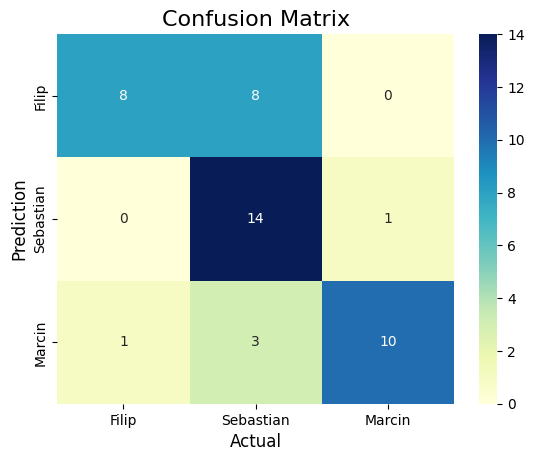

In [107]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
ticks = ["Filip","Sebastian","Marcin"]
# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Random Forest

In [108]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.7777777777777778
              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67        16
         1.0       0.70      0.93      0.80        15
         2.0       0.76      0.93      0.84        14

    accuracy                           0.78        45
   macro avg       0.82      0.79      0.77        45
weighted avg       0.83      0.78      0.76        45



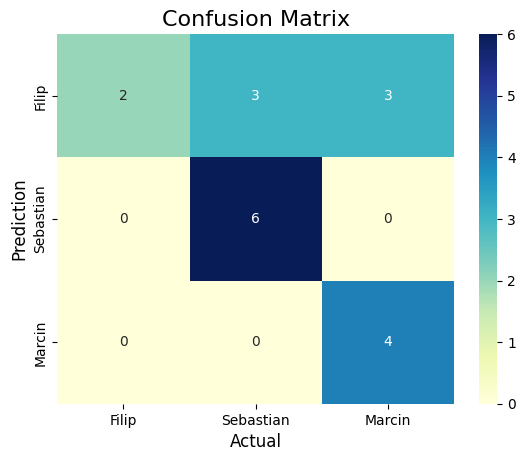

In [100]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
ticks = ["Filip","Sebastian","Marcin"]
# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Multilayer Perceptron

In [109]:
# Step 3: Train the Multilayer Perceptron Classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,100,100,20), activation='relu', solver='adam', 
                         max_iter=3000, random_state=42)
mlp_clf.fit(X_train, y_train)

# Step 4: Evaluate the MLP Classifier
mlp_pred = mlp_clf.predict(X_test)
print("MLP Accuracy:", accuracy_score(y_test, mlp_pred))
print("MLP Classification Report:\n", classification_report(y_test, mlp_pred))

MLP Accuracy: 0.7555555555555555
MLP Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.44      0.61        16
         1.0       0.74      0.93      0.82        15
         2.0       0.68      0.93      0.79        14

    accuracy                           0.76        45
   macro avg       0.81      0.77      0.74        45
weighted avg       0.81      0.76      0.74        45



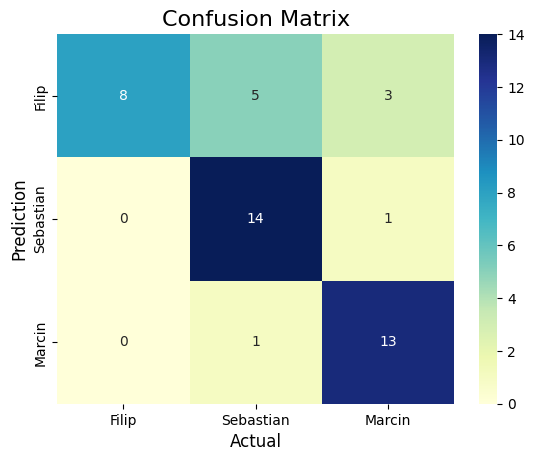

In [110]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
ticks = ["Filip","Sebastian","Marcin"]
# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()